# MLP 224
* Operate on 16000 GenCode 34 seqs.
* 5-way cross validation. Save best model per CV.
* Report mean accuracy from final re-validation with best 5.
* Use Adam with a learn rate decay schdule.

In [1]:
NC_FILENAME='ncRNA.gc34.processed.fasta'
PC_FILENAME='pcRNA.gc34.processed.fasta'
DATAPATH=""
try:
    from google.colab import drive
    IN_COLAB = True
    PATH='/content/drive/'
    drive.mount(PATH)
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    NC_FILENAME = DATAPATH+NC_FILENAME
    PC_FILENAME = DATAPATH+PC_FILENAME
except:
    IN_COLAB = False
    DATAPATH="" 

EPOCHS=200
SPLITS=5
K=4
VOCABULARY_SIZE=4**K+1   # e.g. K=3 => 64 DNA K-mers + 'NNN'
EMBED_DIMEN=16
FILENAME='MLP224'
NEURONS=16

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import GRU
from keras.layers import Dense
from keras.layers import LayerNormalization
import time
dt='float32'
tf.keras.backend.set_floatx(dt)

## Build model

In [3]:
def compile_model(model):
    adam_default_learn_rate = 0.001
    schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate = adam_default_learn_rate*10,
        #decay_steps=100000, decay_rate=0.96, staircase=True)
        decay_steps=10000, decay_rate=0.99, staircase=True)
    # learn rate = initial_learning_rate * decay_rate ^ (step / decay_steps)
    opt = tf.keras.optimizers.Adam(learning_rate=schedule)
    bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    print("COMPILE...")
    model.compile(loss=bc, optimizer=opt, metrics=["accuracy"])
    print("...COMPILED")
    return model

def build_model(maxlen):
    act="elu"
    #embed_layer  = keras.layers.Embedding(
    #    VOCABULARY_SIZE,EMBED_DIMEN,input_length=maxlen);
    dense1_layer = keras.layers.Dense(NEURONS, activation=act,dtype=dt,
                                      input_dim=VOCABULARY_SIZE)
    dense2_layer = keras.layers.Dense(NEURONS, activation=act,dtype=dt)
    #dense3_layer = keras.layers.Dense(NEURONS, activation=act,dtype=dt)
    output_layer = keras.layers.Dense(1,  activation="sigmoid",dtype=dt)
    mlp = keras.models.Sequential()
    #mlp.add(embed_layer)
    mlp.add(dense1_layer)
    mlp.add(dense2_layer)
    #mlp.add(dense3_layer)
    mlp.add(output_layer)
    mlpc = compile_model(mlp)
    return mlpc

## Load and partition sequences

In [4]:
# Assume file was preprocessed to contain one line per seq.
# Prefer Pandas dataframe but df does not support append.
# For conversion to tensor, must avoid python lists.
def load_fasta(filename,label):
    DEFLINE='>'
    labels=[]
    seqs=[]
    lens=[]
    nums=[]
    num=0
    with open (filename,'r') as infile:
        for line in infile:
            if line[0]!=DEFLINE:
                seq=line.rstrip()
                num += 1   # first seqnum is 1
                seqlen=len(seq)
                nums.append(num)
                labels.append(label)
                seqs.append(seq)
                lens.append(seqlen)
    df1=pd.DataFrame(nums,columns=['seqnum'])
    df2=pd.DataFrame(labels,columns=['class'])
    df3=pd.DataFrame(seqs,columns=['sequence'])
    df4=pd.DataFrame(lens,columns=['seqlen'])
    df=pd.concat((df1,df2,df3,df4),axis=1)
    return df

def separate_X_and_y(data):
    y=   data[['class']].copy()
    X=   data.drop(columns=['class','seqnum','seqlen'])
    return (X,y)



## Make K-mers

In [5]:
def make_kmer_table(K):
    npad='N'*K
    shorter_kmers=['']
    for i in range(K):
        longer_kmers=[]
        for mer in shorter_kmers:
            longer_kmers.append(mer+'A')
            longer_kmers.append(mer+'C')
            longer_kmers.append(mer+'G')
            longer_kmers.append(mer+'T')
        shorter_kmers = longer_kmers
    all_kmers = shorter_kmers
    kmer_dict = {}
    kmer_dict[npad]=0
    value=1
    for mer in all_kmers:
        kmer_dict[mer]=value
        value += 1
    return kmer_dict

KMER_TABLE=make_kmer_table(K)

def strings_to_vectors(data,uniform_len):
    all_seqs=[]
    for seq in data['sequence']:
        i=0
        seqlen=len(seq)
        kmers=[]
        while i < seqlen-K+1 -1:  # stop at minus one for spaced seed
            #kmer=seq[i:i+2]+seq[i+3:i+5]    # SPACED SEED 2/1/2 for K=4
            kmer=seq[i:i+K]  
            i += 1
            value=KMER_TABLE[kmer]
            kmers.append(value)
        pad_val=0
        while i < uniform_len:
            kmers.append(pad_val)
            i += 1
        all_seqs.append(kmers)
    pd2d=pd.DataFrame(all_seqs)
    return pd2d   # return 2D dataframe, uniform dimensions

In [6]:
def make_kmers(MAXLEN,train_set):
    (X_train_all,y_train_all)=separate_X_and_y(train_set)
    X_train_kmers=strings_to_vectors(X_train_all,MAXLEN)
    # From pandas dataframe to numpy to list to numpy
    num_seqs=len(X_train_kmers)
    tmp_seqs=[]
    for i in range(num_seqs):
        kmer_sequence=X_train_kmers.iloc[i]
        tmp_seqs.append(kmer_sequence)
    X_train_kmers=np.array(tmp_seqs)
    tmp_seqs=None
    labels=y_train_all.to_numpy()
    return (X_train_kmers,labels)

In [7]:
def make_frequencies(Xin):
    Xout=[]
    VOCABULARY_SIZE= 4**K + 1  # plus one for 'NNN'
    for seq in Xin:
        freqs =[0] * VOCABULARY_SIZE
        total = 0
        for kmerval in seq:
            freqs[kmerval] += 1
            total += 1
        for c in range(VOCABULARY_SIZE):
            freqs[c] = freqs[c]/total
        Xout.append(freqs)
    Xnum = np.asarray(Xout)
    return (Xnum)
def make_slice(data_set,min_len,max_len):
    slice = data_set.query('seqlen <= '+str(max_len)+' & seqlen>= '+str(min_len))
    return slice

## Cross validation

In [8]:
def do_cross_validation(X,y,given_model):
    cv_scores = []
    fold=0
    splitter = ShuffleSplit(n_splits=SPLITS, test_size=0.1, random_state=37863)
    for train_index,valid_index in splitter.split(X):
        fold += 1
        X_train=X[train_index] # use iloc[] for dataframe
        y_train=y[train_index]
        X_valid=X[valid_index]
        y_valid=y[valid_index]        
        # Avoid continually improving the same model.
        model = compile_model(keras.models.clone_model(given_model))
        bestname=DATAPATH+FILENAME+".cv."+str(fold)+".best"
        mycallbacks = [keras.callbacks.ModelCheckpoint(
            filepath=bestname, save_best_only=True, 
            monitor='val_accuracy', mode='max')]   
        print("FIT")
        start_time=time.time()
        history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=EPOCHS, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                callbacks=mycallbacks,
                validation_data=(X_valid,y_valid) )
        end_time=time.time()
        elapsed_time=(end_time-start_time)                        
        print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()
        best_model=keras.models.load_model(bestname)
        scores = best_model.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))
        cv_scores.append(scores[1] * 100)  
    print()
    print("%d-way Cross Validation mean %.2f%% (+/- %.2f%%)" % (fold, np.mean(cv_scores), np.std(cv_scores)))

## Train on RNA lengths 200-1Kb

In [9]:
MINLEN=200
MAXLEN=1000
print("Load data from files.")
nc_seq=load_fasta(NC_FILENAME,0)
pc_seq=load_fasta(PC_FILENAME,1)
print("Take a crude step to balance the data!")
nc_seq = nc_seq[:9040]  # values found empirically by trial and error
train_set=pd.concat((nc_seq,pc_seq),axis=0)
print(len(nc_seq), " non-coding zero")
print(len(pc_seq), " coding one")
print(len(train_set), " total")
nc_seq=None
pc_seq=None
print("Ready: train_set")
#train_set
print ("Data prep")
subset=make_slice(train_set,MINLEN,MAXLEN)
print(len(subset), " subset")
print ("Data reshape")
(X_train,y_train)=make_kmers(MAXLEN,subset)
X_train=make_frequencies(X_train)

Load data from files.
Take a crude step to balance the data!
9040  non-coding zero
16000  coding one
25040  total
Ready: train_set
Data prep
11566  subset
Data reshape


In [10]:
# Imbalance in original data set.
# 16104  total
# 5781  non-zero
# 10323  zero
print(len(y_train)," total")
print(np.count_nonzero(y_train), " non-zero")
print(len(y_train)-np.count_nonzero(y_train), " zero")


11566  total
5781  non-zero
5785  zero


In [11]:
print ("Compile the model")
model=build_model(MAXLEN)
print ("Summarize the model")
print(model.summary())  # Print this only once
model.save(DATAPATH+FILENAME+'.model')


Compile the model
COMPILE...
...COMPILED
Summarize the model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                4128      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 4,417
Trainable params: 4,417
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: MLP224.model/assets


Cross valiation
COMPILE...
...COMPILED
FIT
Epoch 1/200
326/326 [==============================] - 2s 5ms/step - loss: 0.4912 - accuracy: 0.7556 - val_loss: 0.4256 - val_accuracy: 0.8107
Epoch 2/200
326/326 [==============================] - 1s 2ms/step - loss: 0.4041 - accuracy: 0.8141 - val_loss: 0.4375 - val_accuracy: 0.7917
Epoch 3/200
326/326 [==============================] - 1s 4ms/step - loss: 0.3960 - accuracy: 0.8202 - val_loss: 0.3769 - val_accuracy: 0.8384
Epoch 4/200
326/326 [==============================] - 1s 4ms/step - loss: 0.3998 - accuracy: 0.8191 - val_loss: 0.3728 - val_accuracy: 0.8401
Epoch 5/200
326/326 [==============================] - 1s 2ms/step - loss: 0.3911 - accuracy: 0.8210 - val_loss: 0.3677 - val_accuracy: 0.8384
Epoch 6/200
326/326 [==============================] - 1s 2ms/step - loss: 0.3954 - accuracy: 0.8220 - val_loss: 0.3736 - val_accuracy: 0.8323
Epoch 7/200
326/326 [==============================] - 1s 4ms/step - loss: 0.3866 - accuracy: 0.823

Epoch 52/200
326/326 [==============================] - 1s 2ms/step - loss: 0.3247 - accuracy: 0.8603 - val_loss: 0.3537 - val_accuracy: 0.8496
Epoch 53/200
326/326 [==============================] - 1s 2ms/step - loss: 0.3203 - accuracy: 0.8602 - val_loss: 0.3505 - val_accuracy: 0.8462
Epoch 54/200
326/326 [==============================] - 1s 2ms/step - loss: 0.3201 - accuracy: 0.8621 - val_loss: 0.3675 - val_accuracy: 0.8392
Epoch 55/200
326/326 [==============================] - 1s 2ms/step - loss: 0.3211 - accuracy: 0.8620 - val_loss: 0.3599 - val_accuracy: 0.8470
Epoch 56/200
326/326 [==============================] - 1s 2ms/step - loss: 0.3201 - accuracy: 0.8675 - val_loss: 0.3615 - val_accuracy: 0.8410
Epoch 57/200
326/326 [==============================] - 1s 2ms/step - loss: 0.3200 - accuracy: 0.8642 - val_loss: 0.3612 - val_accuracy: 0.8453
Epoch 58/200
326/326 [==============================] - 1s 2ms/step - loss: 0.3182 - accuracy: 0.8643 - val_loss: 0.3517 - val_accuracy:

Epoch 109/200
326/326 [==============================] - 1s 3ms/step - loss: 0.2859 - accuracy: 0.8799 - val_loss: 0.3689 - val_accuracy: 0.8496
Epoch 110/200
326/326 [==============================] - 1s 2ms/step - loss: 0.2870 - accuracy: 0.8770 - val_loss: 0.3787 - val_accuracy: 0.8358
Epoch 111/200
326/326 [==============================] - 1s 2ms/step - loss: 0.2830 - accuracy: 0.8836 - val_loss: 0.3690 - val_accuracy: 0.8496
Epoch 112/200
326/326 [==============================] - 1s 2ms/step - loss: 0.2837 - accuracy: 0.8814 - val_loss: 0.3685 - val_accuracy: 0.8496
Epoch 113/200
326/326 [==============================] - 1s 2ms/step - loss: 0.2818 - accuracy: 0.8792 - val_loss: 0.3849 - val_accuracy: 0.8462
Epoch 114/200
326/326 [==============================] - 1s 2ms/step - loss: 0.2857 - accuracy: 0.8757 - val_loss: 0.4021 - val_accuracy: 0.8358
Epoch 115/200
326/326 [==============================] - 1s 2ms/step - loss: 0.2849 - accuracy: 0.8765 - val_loss: 0.3802 - val_ac

326/326 [==============================] - 1s 2ms/step - loss: 0.2566 - accuracy: 0.8910 - val_loss: 0.3970 - val_accuracy: 0.8245
Epoch 166/200
326/326 [==============================] - 1s 2ms/step - loss: 0.2619 - accuracy: 0.8892 - val_loss: 0.3975 - val_accuracy: 0.8392
Epoch 167/200
326/326 [==============================] - 1s 3ms/step - loss: 0.2595 - accuracy: 0.8897 - val_loss: 0.4010 - val_accuracy: 0.8341
Epoch 168/200
326/326 [==============================] - 1s 2ms/step - loss: 0.2582 - accuracy: 0.8916 - val_loss: 0.4197 - val_accuracy: 0.8280
Epoch 169/200
326/326 [==============================] - 1s 2ms/step - loss: 0.2618 - accuracy: 0.8903 - val_loss: 0.3922 - val_accuracy: 0.8470
Epoch 170/200
326/326 [==============================] - 1s 4ms/step - loss: 0.2590 - accuracy: 0.8898 - val_loss: 0.4098 - val_accuracy: 0.8341
Epoch 171/200
326/326 [==============================] - 1s 2ms/step - loss: 0.2609 - accuracy: 0.8896 - val_loss: 0.4112 - val_accuracy: 0.8418

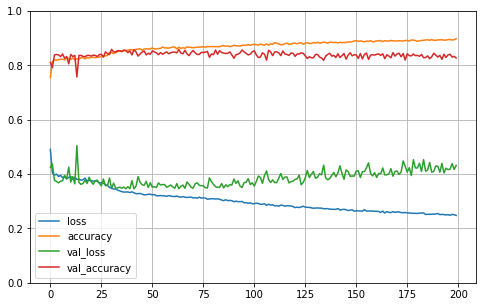

accuracy: 85.91%
COMPILE...
...COMPILED
FIT
Epoch 1/200
326/326 [==============================] - 1s 4ms/step - loss: 0.4853 - accuracy: 0.7604 - val_loss: 0.4821 - val_accuracy: 0.7865
Epoch 2/200
326/326 [==============================] - 1s 3ms/step - loss: 0.4175 - accuracy: 0.8071 - val_loss: 0.4417 - val_accuracy: 0.8003
Epoch 3/200
326/326 [==============================] - 1s 2ms/step - loss: 0.3912 - accuracy: 0.8230 - val_loss: 0.4606 - val_accuracy: 0.7857
Epoch 4/200
326/326 [==============================] - 1s 4ms/step - loss: 0.4011 - accuracy: 0.8169 - val_loss: 0.4320 - val_accuracy: 0.8073
Epoch 5/200
326/326 [==============================] - 1s 3ms/step - loss: 0.3883 - accuracy: 0.8239 - val_loss: 0.3909 - val_accuracy: 0.8150
Epoch 6/200
326/326 [==============================] - 1s 4ms/step - loss: 0.3857 - accuracy: 0.8263 - val_loss: 0.4008 - val_accuracy: 0.8159
Epoch 7/200
326/326 [==============================] - 2s 5ms/step - loss: 0.3849 - accuracy: 0.82

Epoch 48/200
326/326 [==============================] - 1s 3ms/step - loss: 0.3239 - accuracy: 0.8626 - val_loss: 0.3872 - val_accuracy: 0.8366
Epoch 49/200
326/326 [==============================] - 1s 2ms/step - loss: 0.3252 - accuracy: 0.8585 - val_loss: 0.3575 - val_accuracy: 0.8392
Epoch 50/200
326/326 [==============================] - 1s 4ms/step - loss: 0.3251 - accuracy: 0.8610 - val_loss: 0.3728 - val_accuracy: 0.8418
Epoch 51/200
326/326 [==============================] - 1s 2ms/step - loss: 0.3252 - accuracy: 0.8606 - val_loss: 0.3901 - val_accuracy: 0.8306
Epoch 52/200
326/326 [==============================] - 1s 3ms/step - loss: 0.3233 - accuracy: 0.8624 - val_loss: 0.3681 - val_accuracy: 0.8245
Epoch 53/200
326/326 [==============================] - 1s 3ms/step - loss: 0.3257 - accuracy: 0.8590 - val_loss: 0.3759 - val_accuracy: 0.8271
Epoch 54/200
326/326 [==============================] - 1s 2ms/step - loss: 0.3209 - accuracy: 0.8642 - val_loss: 0.4227 - val_accuracy:

326/326 [==============================] - 1s 2ms/step - loss: 0.3021 - accuracy: 0.8716 - val_loss: 0.3728 - val_accuracy: 0.8453
Epoch 102/200
326/326 [==============================] - 1s 2ms/step - loss: 0.2985 - accuracy: 0.8695 - val_loss: 0.3939 - val_accuracy: 0.8211
Epoch 103/200
326/326 [==============================] - 1s 4ms/step - loss: 0.3013 - accuracy: 0.8678 - val_loss: 0.3709 - val_accuracy: 0.8496
Epoch 104/200
326/326 [==============================] - 1s 2ms/step - loss: 0.3027 - accuracy: 0.8684 - val_loss: 0.3835 - val_accuracy: 0.8384
Epoch 105/200
326/326 [==============================] - 1s 2ms/step - loss: 0.3002 - accuracy: 0.8694 - val_loss: 0.3774 - val_accuracy: 0.8384
Epoch 106/200
326/326 [==============================] - 1s 2ms/step - loss: 0.3000 - accuracy: 0.8728 - val_loss: 0.3834 - val_accuracy: 0.8384
Epoch 107/200
326/326 [==============================] - 1s 2ms/step - loss: 0.2981 - accuracy: 0.8698 - val_loss: 0.3898 - val_accuracy: 0.8341

326/326 [==============================] - 1s 2ms/step - loss: 0.2730 - accuracy: 0.8839 - val_loss: 0.3924 - val_accuracy: 0.8436
Epoch 156/200
326/326 [==============================] - 1s 4ms/step - loss: 0.2727 - accuracy: 0.8853 - val_loss: 0.4093 - val_accuracy: 0.8263
Epoch 157/200
326/326 [==============================] - 1s 3ms/step - loss: 0.2758 - accuracy: 0.8816 - val_loss: 0.3898 - val_accuracy: 0.8444
Epoch 158/200
326/326 [==============================] - 1s 2ms/step - loss: 0.2760 - accuracy: 0.8837 - val_loss: 0.4073 - val_accuracy: 0.8410
Epoch 159/200
326/326 [==============================] - 1s 2ms/step - loss: 0.2711 - accuracy: 0.8851 - val_loss: 0.3987 - val_accuracy: 0.8418
Epoch 160/200
326/326 [==============================] - 1s 2ms/step - loss: 0.2694 - accuracy: 0.8863 - val_loss: 0.4158 - val_accuracy: 0.8410
Epoch 161/200
326/326 [==============================] - 1s 2ms/step - loss: 0.2721 - accuracy: 0.8850 - val_loss: 0.3966 - val_accuracy: 0.8358

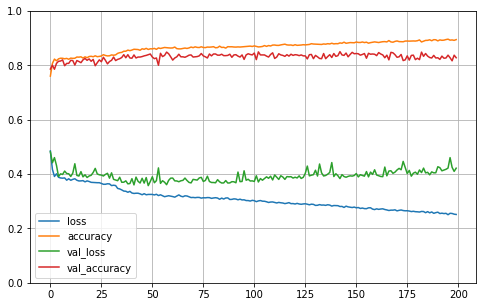

accuracy: 85.05%
COMPILE...
...COMPILED
FIT
Epoch 1/200
326/326 [==============================] - 1s 4ms/step - loss: 0.4923 - accuracy: 0.7484 - val_loss: 0.4040 - val_accuracy: 0.8280
Epoch 2/200
326/326 [==============================] - 1s 3ms/step - loss: 0.4052 - accuracy: 0.8128 - val_loss: 0.3987 - val_accuracy: 0.8245
Epoch 3/200
326/326 [==============================] - 1s 2ms/step - loss: 0.3979 - accuracy: 0.8181 - val_loss: 0.4664 - val_accuracy: 0.7753
Epoch 4/200
326/326 [==============================] - 2s 5ms/step - loss: 0.3908 - accuracy: 0.8250 - val_loss: 0.3861 - val_accuracy: 0.8366
Epoch 5/200
326/326 [==============================] - 1s 3ms/step - loss: 0.3872 - accuracy: 0.8223 - val_loss: 0.4175 - val_accuracy: 0.8064
Epoch 6/200
326/326 [==============================] - 1s 4ms/step - loss: 0.3908 - accuracy: 0.8220 - val_loss: 0.3847 - val_accuracy: 0.8375
Epoch 7/200
326/326 [==============================] - 1s 2ms/step - loss: 0.3858 - accuracy: 0.82

326/326 [==============================] - 1s 2ms/step - loss: 0.3247 - accuracy: 0.8594 - val_loss: 0.3670 - val_accuracy: 0.8505
Epoch 48/200
326/326 [==============================] - 1s 2ms/step - loss: 0.3206 - accuracy: 0.8638 - val_loss: 0.3688 - val_accuracy: 0.8479
Epoch 49/200
326/326 [==============================] - 1s 3ms/step - loss: 0.3216 - accuracy: 0.8593 - val_loss: 0.3644 - val_accuracy: 0.8531
Epoch 50/200
326/326 [==============================] - 1s 4ms/step - loss: 0.3215 - accuracy: 0.8614 - val_loss: 0.3780 - val_accuracy: 0.8479
Epoch 51/200
326/326 [==============================] - 1s 3ms/step - loss: 0.3238 - accuracy: 0.8590 - val_loss: 0.4862 - val_accuracy: 0.8003
Epoch 52/200
326/326 [==============================] - 1s 3ms/step - loss: 0.3205 - accuracy: 0.8605 - val_loss: 0.3686 - val_accuracy: 0.8479
Epoch 53/200
326/326 [==============================] - 1s 2ms/step - loss: 0.3231 - accuracy: 0.8572 - val_loss: 0.3677 - val_accuracy: 0.8453
Epoch

326/326 [==============================] - 1s 3ms/step - loss: 0.2913 - accuracy: 0.8764 - val_loss: 0.3774 - val_accuracy: 0.8366
Epoch 104/200
326/326 [==============================] - 1s 2ms/step - loss: 0.2903 - accuracy: 0.8770 - val_loss: 0.3795 - val_accuracy: 0.8487
Epoch 105/200
326/326 [==============================] - 1s 2ms/step - loss: 0.2890 - accuracy: 0.8784 - val_loss: 0.3897 - val_accuracy: 0.8349
Epoch 106/200
326/326 [==============================] - 1s 2ms/step - loss: 0.2897 - accuracy: 0.8731 - val_loss: 0.3782 - val_accuracy: 0.8366
Epoch 107/200
326/326 [==============================] - 1s 2ms/step - loss: 0.2948 - accuracy: 0.8742 - val_loss: 0.3790 - val_accuracy: 0.8436
Epoch 108/200
326/326 [==============================] - 1s 2ms/step - loss: 0.2841 - accuracy: 0.8795 - val_loss: 0.4063 - val_accuracy: 0.8271
Epoch 109/200
326/326 [==============================] - 1s 2ms/step - loss: 0.2850 - accuracy: 0.8789 - val_loss: 0.3926 - val_accuracy: 0.8323

326/326 [==============================] - 1s 2ms/step - loss: 0.2657 - accuracy: 0.8895 - val_loss: 0.3976 - val_accuracy: 0.8297
Epoch 160/200
326/326 [==============================] - 1s 2ms/step - loss: 0.2663 - accuracy: 0.8890 - val_loss: 0.4017 - val_accuracy: 0.8418
Epoch 161/200
326/326 [==============================] - 1s 2ms/step - loss: 0.2684 - accuracy: 0.8849 - val_loss: 0.4045 - val_accuracy: 0.8228
Epoch 162/200
326/326 [==============================] - 1s 3ms/step - loss: 0.2646 - accuracy: 0.8872 - val_loss: 0.4236 - val_accuracy: 0.8263
Epoch 163/200
326/326 [==============================] - 1s 2ms/step - loss: 0.2645 - accuracy: 0.8907 - val_loss: 0.3956 - val_accuracy: 0.8332
Epoch 164/200
326/326 [==============================] - 1s 2ms/step - loss: 0.2622 - accuracy: 0.8908 - val_loss: 0.4045 - val_accuracy: 0.8384
Epoch 165/200
326/326 [==============================] - 1s 2ms/step - loss: 0.2618 - accuracy: 0.8887 - val_loss: 0.3969 - val_accuracy: 0.8410

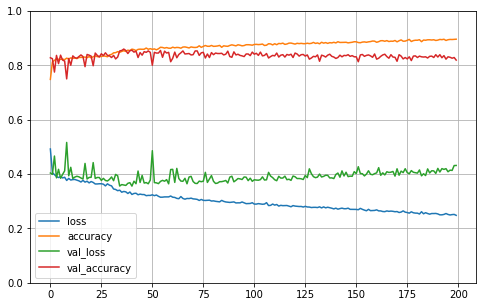

accuracy: 86.00%
COMPILE...
...COMPILED
FIT
Epoch 1/200
326/326 [==============================] - 1s 4ms/step - loss: 0.5077 - accuracy: 0.7430 - val_loss: 0.3943 - val_accuracy: 0.8211
Epoch 2/200
326/326 [==============================] - 1s 3ms/step - loss: 0.4135 - accuracy: 0.8084 - val_loss: 0.4579 - val_accuracy: 0.7649
Epoch 3/200
326/326 [==============================] - 1s 2ms/step - loss: 0.4009 - accuracy: 0.8189 - val_loss: 0.4062 - val_accuracy: 0.8021
Epoch 4/200
326/326 [==============================] - 1s 2ms/step - loss: 0.3944 - accuracy: 0.8204 - val_loss: 0.3892 - val_accuracy: 0.8202
Epoch 5/200
326/326 [==============================] - 2s 5ms/step - loss: 0.3903 - accuracy: 0.8234 - val_loss: 0.3872 - val_accuracy: 0.8289
Epoch 6/200
326/326 [==============================] - 1s 4ms/step - loss: 0.3865 - accuracy: 0.8260 - val_loss: 0.3698 - val_accuracy: 0.8349
Epoch 7/200
326/326 [==============================] - 1s 3ms/step - loss: 0.3836 - accuracy: 0.82

326/326 [==============================] - 1s 3ms/step - loss: 0.3269 - accuracy: 0.8579 - val_loss: 0.3724 - val_accuracy: 0.8436
Epoch 51/200
326/326 [==============================] - 1s 4ms/step - loss: 0.3228 - accuracy: 0.8587 - val_loss: 0.3591 - val_accuracy: 0.8384
Epoch 52/200
326/326 [==============================] - 1s 3ms/step - loss: 0.3213 - accuracy: 0.8622 - val_loss: 0.3662 - val_accuracy: 0.8384
Epoch 53/200
326/326 [==============================] - 1s 2ms/step - loss: 0.3195 - accuracy: 0.8629 - val_loss: 0.3690 - val_accuracy: 0.8418
Epoch 54/200
326/326 [==============================] - 1s 2ms/step - loss: 0.3234 - accuracy: 0.8619 - val_loss: 0.3637 - val_accuracy: 0.8392
Epoch 55/200
326/326 [==============================] - 1s 3ms/step - loss: 0.3198 - accuracy: 0.8607 - val_loss: 0.3763 - val_accuracy: 0.8418
Epoch 56/200
326/326 [==============================] - 1s 3ms/step - loss: 0.3182 - accuracy: 0.8594 - val_loss: 0.3709 - val_accuracy: 0.8349
Epoch

Epoch 107/200
326/326 [==============================] - 1s 2ms/step - loss: 0.2860 - accuracy: 0.8771 - val_loss: 0.4039 - val_accuracy: 0.8375
Epoch 108/200
326/326 [==============================] - 1s 2ms/step - loss: 0.2814 - accuracy: 0.8782 - val_loss: 0.4015 - val_accuracy: 0.8341
Epoch 109/200
326/326 [==============================] - 1s 2ms/step - loss: 0.2834 - accuracy: 0.8798 - val_loss: 0.3812 - val_accuracy: 0.8332
Epoch 110/200
326/326 [==============================] - 1s 2ms/step - loss: 0.2786 - accuracy: 0.8794 - val_loss: 0.3887 - val_accuracy: 0.8297
Epoch 111/200
326/326 [==============================] - 1s 2ms/step - loss: 0.2801 - accuracy: 0.8810 - val_loss: 0.3953 - val_accuracy: 0.8401
Epoch 112/200
326/326 [==============================] - 1s 2ms/step - loss: 0.2804 - accuracy: 0.8793 - val_loss: 0.4046 - val_accuracy: 0.8297
Epoch 113/200
326/326 [==============================] - 1s 2ms/step - loss: 0.2811 - accuracy: 0.8778 - val_loss: 0.3925 - val_ac

326/326 [==============================] - 1s 2ms/step - loss: 0.2559 - accuracy: 0.8941 - val_loss: 0.4270 - val_accuracy: 0.8211
Epoch 164/200
326/326 [==============================] - 1s 2ms/step - loss: 0.2569 - accuracy: 0.8918 - val_loss: 0.4164 - val_accuracy: 0.8323
Epoch 165/200
326/326 [==============================] - 1s 2ms/step - loss: 0.2551 - accuracy: 0.8939 - val_loss: 0.4799 - val_accuracy: 0.8150
Epoch 166/200
326/326 [==============================] - 1s 2ms/step - loss: 0.2574 - accuracy: 0.8924 - val_loss: 0.4142 - val_accuracy: 0.8237
Epoch 167/200
326/326 [==============================] - 1s 2ms/step - loss: 0.2499 - accuracy: 0.8955 - val_loss: 0.4176 - val_accuracy: 0.8254
Epoch 168/200
326/326 [==============================] - 1s 2ms/step - loss: 0.2524 - accuracy: 0.8950 - val_loss: 0.4294 - val_accuracy: 0.8228
Epoch 169/200
326/326 [==============================] - 1s 2ms/step - loss: 0.2539 - accuracy: 0.8953 - val_loss: 0.4178 - val_accuracy: 0.8220

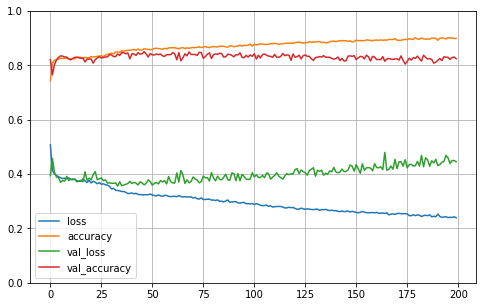

accuracy: 85.05%
COMPILE...
...COMPILED
FIT
Epoch 1/200
326/326 [==============================] - 1s 4ms/step - loss: 0.4841 - accuracy: 0.7603 - val_loss: 0.4124 - val_accuracy: 0.8245
Epoch 2/200
326/326 [==============================] - 1s 3ms/step - loss: 0.4088 - accuracy: 0.8158 - val_loss: 0.4169 - val_accuracy: 0.8142
Epoch 3/200
326/326 [==============================] - 1s 2ms/step - loss: 0.4003 - accuracy: 0.8196 - val_loss: 0.4030 - val_accuracy: 0.8194
Epoch 4/200
326/326 [==============================] - 1s 2ms/step - loss: 0.3897 - accuracy: 0.8221 - val_loss: 0.4453 - val_accuracy: 0.7995
Epoch 5/200
326/326 [==============================] - 1s 2ms/step - loss: 0.3926 - accuracy: 0.8206 - val_loss: 0.4189 - val_accuracy: 0.8055
Epoch 6/200
326/326 [==============================] - 1s 2ms/step - loss: 0.3869 - accuracy: 0.8243 - val_loss: 0.4391 - val_accuracy: 0.7952
Epoch 7/200
326/326 [==============================] - 1s 4ms/step - loss: 0.3854 - accuracy: 0.82

Epoch 51/200
326/326 [==============================] - 1s 3ms/step - loss: 0.3205 - accuracy: 0.8647 - val_loss: 0.3781 - val_accuracy: 0.8470
Epoch 52/200
326/326 [==============================] - 1s 2ms/step - loss: 0.3233 - accuracy: 0.8593 - val_loss: 0.3667 - val_accuracy: 0.8462
Epoch 53/200
326/326 [==============================] - 1s 2ms/step - loss: 0.3197 - accuracy: 0.8625 - val_loss: 0.3756 - val_accuracy: 0.8375
Epoch 54/200
326/326 [==============================] - 1s 2ms/step - loss: 0.3215 - accuracy: 0.8623 - val_loss: 0.3752 - val_accuracy: 0.8366
Epoch 55/200
326/326 [==============================] - 1s 2ms/step - loss: 0.3227 - accuracy: 0.8633 - val_loss: 0.3599 - val_accuracy: 0.8522
Epoch 56/200
326/326 [==============================] - 1s 2ms/step - loss: 0.3218 - accuracy: 0.8597 - val_loss: 0.3679 - val_accuracy: 0.8453
Epoch 57/200
326/326 [==============================] - 1s 2ms/step - loss: 0.3169 - accuracy: 0.8648 - val_loss: 0.3815 - val_accuracy:

Epoch 108/200
326/326 [==============================] - 1s 4ms/step - loss: 0.2939 - accuracy: 0.8732 - val_loss: 0.3642 - val_accuracy: 0.8583
Epoch 109/200
326/326 [==============================] - 1s 3ms/step - loss: 0.2915 - accuracy: 0.8738 - val_loss: 0.3633 - val_accuracy: 0.8539
Epoch 110/200
326/326 [==============================] - 2s 5ms/step - loss: 0.2915 - accuracy: 0.8792 - val_loss: 0.3893 - val_accuracy: 0.8487
Epoch 111/200
326/326 [==============================] - 1s 2ms/step - loss: 0.2926 - accuracy: 0.8729 - val_loss: 0.3784 - val_accuracy: 0.8366
Epoch 112/200
326/326 [==============================] - 1s 2ms/step - loss: 0.2892 - accuracy: 0.8749 - val_loss: 0.3686 - val_accuracy: 0.8505
Epoch 113/200
326/326 [==============================] - 1s 2ms/step - loss: 0.2899 - accuracy: 0.8748 - val_loss: 0.3628 - val_accuracy: 0.8436
Epoch 114/200
326/326 [==============================] - 1s 2ms/step - loss: 0.2881 - accuracy: 0.8766 - val_loss: 0.3707 - val_ac

326/326 [==============================] - 1s 2ms/step - loss: 0.2619 - accuracy: 0.8859 - val_loss: 0.4074 - val_accuracy: 0.8401
Epoch 164/200
326/326 [==============================] - 1s 2ms/step - loss: 0.2639 - accuracy: 0.8864 - val_loss: 0.3880 - val_accuracy: 0.8392
Epoch 165/200
326/326 [==============================] - 1s 2ms/step - loss: 0.2612 - accuracy: 0.8882 - val_loss: 0.4205 - val_accuracy: 0.8349
Epoch 166/200
326/326 [==============================] - 1s 2ms/step - loss: 0.2617 - accuracy: 0.8881 - val_loss: 0.3917 - val_accuracy: 0.8375
Epoch 167/200
326/326 [==============================] - 1s 2ms/step - loss: 0.2632 - accuracy: 0.8856 - val_loss: 0.3973 - val_accuracy: 0.8392
Epoch 168/200
326/326 [==============================] - 1s 2ms/step - loss: 0.2598 - accuracy: 0.8896 - val_loss: 0.3889 - val_accuracy: 0.8418
Epoch 169/200
326/326 [==============================] - 1s 2ms/step - loss: 0.2613 - accuracy: 0.8890 - val_loss: 0.3984 - val_accuracy: 0.8392

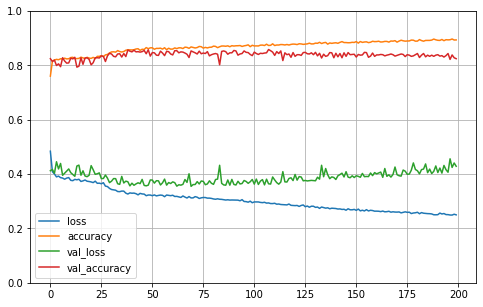

accuracy: 85.83%

5-way Cross Validation mean 85.57% (+/- 0.43%)
Done


In [12]:
print ("Cross valiation")
do_cross_validation(X_train,y_train,model)  
print ("Done")